<a href="https://colab.research.google.com/github/ArtemChemist/CFU_counter/blob/main/Baseline_CNN_224dpi_5reps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
from datetime import datetime
import time
import csv

import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop

from sklearn.model_selection import train_test_split


In [3]:
# Set up folder
SIZE = 224 #Size of the images this model will deal with
IMDIM = 3
IMG_SIZE = (SIZE, SIZE)            # Define the image size
INPUT_SHAPE = (*IMG_SIZE, IMDIM)       # Define the input_shape

Filters = 16
BATCH_SIZE = 32
EPOCHS = 100
TEST_SIZE = 0.3   # Validation/Train split ratio

RAND_SEED  = 42 # The answer to the ultimate question of life, the universe, and everything

num_classes = 2  # Number of clases for prediction

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip -q "/content/drive/My Drive/224_nothresh.zip" -d "/content"
!unzip -q "/content/drive/My Drive/224.zip" -d "/content"

In [6]:
# Set up folder, unless it is already set up
p = os.path.abspath('.')
input_dir = os.path.join(p, f'{SIZE}')

# Read filenames in the thresholded folder
image_names = []
labels = []

for file in glob.glob(f'{input_dir}/*.jpg'):
	filename = file.split('/')[-1]
	num_colonies = int(filename.split('-')[2].strip().split('.')[0])
	if num_colonies == 0:
		labels.append(0)
	else:
		labels.append(1)
	image_names.append(filename)

X_files = np.array(image_names) #  Array with image nbames
y = np.array(labels)			#  Array with binary labels

print(f'Full dataset: {np.sum(y)} images with bacteria and {len(y)-np.sum(y)} without')

Full dataset: 300 images with bacteria and 3479 without


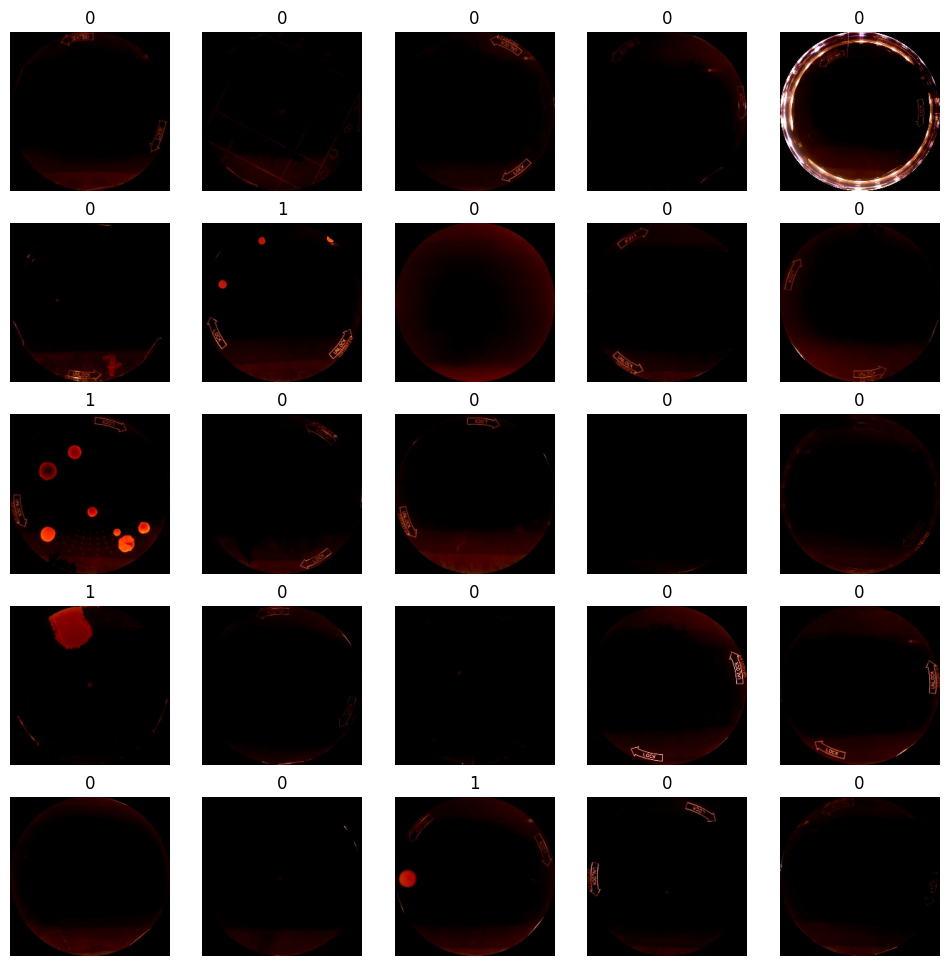

In [7]:
# Visualize random 25 images to make sure it makes sense
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = np.random.choice(np.arange(len(y)))
    file = os.path.join(input_dir, X_files[idx])
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    axs[i,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i,j].set_title(y[idx])
    axs[i,j].axis('off')

plt.show()

In [8]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, PrecisionRecallDisplay, precision_recall_curve
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

def prepare_files(X, y, test_size=TEST_SIZE, random_state=RAND_SEED):
    # On the highly imbalanced dataset I can not rely on the random split between training and val sets
    # Test subset can randomly have too few or too many positive cases
    # Have to select pre-defined number of random images from each class and stack them together
    np.random.seed(RAND_SEED) # For reproducibility

    #  Make two arrays with images: one for positive and one for negative images
    pos_im = [X[i] for i in range(X.shape[0]) if y[i]]
    pos_im = np.array(pos_im)
    neg_im = [X[i] for i in range(X.shape[0]) if not y[i]]
    neg_im = np.array(neg_im)
    num_pos = pos_im.shape[0]
    num_neg = neg_im.shape[0]
    print(f'Full dataset: {num_pos} images with bacteria and {num_neg} without')

    # Select random positive images
    # Make two random indeces for val and train
    idx_pos_val = np.random.choice(np.arange(num_pos), int(num_pos*TEST_SIZE), replace = False)
    idx_pos_train = [i for i in np.arange(num_pos) if i not in idx_pos_val]
    #  Apply this index to the array of image names
    X_val_pos = pos_im[idx_pos_val]
    X_train_pos = pos_im[idx_pos_train]
    y_val_pos = np.ones(len(idx_pos_val))
    y_train_pos = np.ones(len(idx_pos_train))

    # Select random negative images
    # Make two random indeces for val and train
    idx_neg_val = np.random.choice(np.arange(num_neg), int(num_neg*TEST_SIZE), replace = False)
    idx_neg_train = [i for i in np.arange(num_neg) if i not in idx_neg_val]
    #  Apply this index to the array of image names
    X_val_neg = neg_im[idx_neg_val]
    X_train_neg = neg_im[idx_neg_train]
    y_val_neg = np.zeros(len(idx_neg_val))
    y_train_neg = np.zeros(len(idx_neg_train))

    # Stack two classes together
    X_val = np.concatenate((X_val_neg, X_val_pos), axis = 0)
    y_val = np.concatenate((y_val_neg, y_val_pos), axis = 0)
    X_train = np.concatenate((X_train_neg, X_train_pos), axis = 0)
    y_train = np.concatenate((y_train_neg, y_train_pos), axis = 0)

    # Shuffle validation
    print("Suffling validation dataset ....")
    num_val = X_val.shape[0]
    indices = np.arange(num_val)
    shuffled_indices = np.random.permutation(indices)
    X_val = X_val[shuffled_indices]
    y_val = y_val[shuffled_indices]
    print(f"{X_val.shape} - {y_val.shape}")

    # Shuffle training
    print("Suffling trainig dataset ....")
    num_train = X_train.shape[0]
    indices = np.arange(num_train)
    shuffled_indices = np.random.permutation(indices)
    X_train = X_train[shuffled_indices]
    y_train = y_train[shuffled_indices]

    #Conver to np array and normalize
    y_train = np.array(y_train).astype(int)
    y_val = np.array(y_val).astype(int)

    # Convert labeles to categorical
    num_classes = max(np.max(y_train), np.max(y_val)) + 1
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_val = to_categorical(y_val, num_classes=num_classes)

    print(f"Vlaidation X: {X_val.shape}; y: {y_val.shape}")
    print(f"Training X: {X_train.shape}; y: {y_train.shape}")

    return X_train, X_val, y_train, y_val


In [9]:
def make_conv_layers(input_shape):

    conv_layers = Sequential()

    # Zero'th convolutional layer
    conv_layers.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    conv_layers.add(BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # First convolutional layer
    conv_layers.add(Conv2D(32, (3, 3), activation='relu'))
    conv_layers.add(BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer
    conv_layers.add(Conv2D(64, (5, 5), activation='relu'))
    conv_layers.add(BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional layer
    conv_layers.add(Conv2D(128, (5, 5), activation='relu'))
    conv_layers.add(BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    conv_layers.add(Flatten())

    return conv_layers

def create_cnn_model(conv_layers, num_classes):
    conv_layers.add(Dense(512, activation='relu'))
    conv_layers.add(Dropout(0.5))
    conv_layers.add(Dense(num_classes, activation='softmax'))
    return conv_layers

class CustomStopper(EarlyStopping):
    def __init__(self, monitor='val_loss',
             patience=5, verbose=0, mode='auto', start_epoch = 10, restore_best_weights=True): # add argument for starting epoch
        super(CustomStopper, self).__init__()
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

early_stopping = CustomStopper()

In [10]:
def read_images(files, file_dir):
  print(f"Reading {len(files)} images from {file_dir.split('/')[-1]}...", end = " ")
  X = []
  for file_name in files:
      file = os.path.join(file_dir, file_name)
      img = cv2.imread(file, cv2.IMREAD_COLOR)
      X.append(img)
  X = np.array(X).astype(np.float32)/255
  print("Done")
  return X

In [11]:
# Train model predefined number of times, increasing the random seed every time
# Collect data on precision-recall curves for each model as well as history for each trianing run
for iter in range(5):
  print (f"Start iteration {iter}")
  # Get the names of the files that will be used for both thresholded and non-thresholded images
  X_train_names, X_val_names, y_train, y_val = prepare_files(X_files, y, test_size=TEST_SIZE, random_state=RAND_SEED+iter)

  '''
  DO NON THRESHOLDED FIRST
  '''

  # Read the actual files
  print("Reading images...")
  no_thr_dir = os.path.join(p, f'{SIZE}_nothresh')   #Set the folder where nonthreholded files live
  X_train = read_images(X_train_names, no_thr_dir)
  X_val = read_images(X_val_names, no_thr_dir)

  # Create a TensorFlow Dataset
  train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  # Define and compile the CNN model
  conv_layers = make_conv_layers(INPUT_SHAPE)
  cnn_model = create_cnn_model(conv_layers, num_classes)
  cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Train the model with the early stopping callback
  print("Training model...")
  start_time = time.time()
  cnn_history = cnn_model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose = False, callbacks=[early_stopping])
  end_time = time.time()

  print(f"{iter}'th no threshold dataset training took {end_time - start_time:.2f} seconds")

  #Set up dir for saving resulting data
  print("Saving data...")
  p = os.path.abspath('.')
  model_dir = os.path.join(p, "drive", "MyDrive", 'Baseline_CNN')

  # Save precision, recal, thresholds into a csv
  y_true = np.argmax(y_val, axis=1)
  y_pred = cnn_model.predict(X_val)
  precision, recall, thresholds = precision_recall_curve(y_true, y_pred[:,1])

  filename = os.path.join(model_dir, 'prec_rec_baseline224_nothresh.csv')
  if os.path.exists(filename):
      append_write = 'a+' # append if already exists
  else:
      append_write = 'w+' # make a new file if not
  with open(filename, append_write) as file_prrec:
    csvwriter = csv.DictWriter(file_prrec, delimiter='\t', fieldnames=["iter", "thresholded?", "threshold", "precision", "recall"])
    if iter == 0 :
      csvwriter.writeheader()
    for thr, pr, rec in zip(thresholds, precision, recall):
      csvwriter.writerow({"iter":iter, "thresholded?": 0,
                          "threshold":thr,
                          "precision":pr,
                          "recall":rec})

  # Save history into a csv
  filename = os.path.join(model_dir, 'history_baseline224_nothresh.csv')
  if os.path.exists(filename):
      append_write = 'a+' # append if already exists
  else:
      append_write = 'w+' # make a new file if not
  with open(filename, append_write) as file_hist:
    csvwriter = csv.DictWriter(file_hist, delimiter='\t', fieldnames=["iter", "thresholded?", "epoch", "train_loss", "train_acc", "val_loss", "val_acc"])
    if iter == 0 :
      csvwriter.writeheader()
    for i in range(len(cnn_history.history['val_loss'])):
      csvwriter.writerow({"iter":iter, "thresholded?": 0,
                          "epoch":i+1,
                          "train_loss":cnn_history.history['loss'][i],
                          "train_acc":cnn_history.history['accuracy'][i],
                          "val_loss":cnn_history.history['val_loss'][i],
                          "val_acc":cnn_history.history['val_accuracy'][i]})

  '''
  REPEAT THE SAME FOR IMAGES WITH THRESHOLDING
  '''
  print("Reading images...")
  thr_dir = os.path.join(p, f'{SIZE}')   #Set the folder where threholded files live
  X_train_thr = read_images(X_train_names, thr_dir)
  X_val_thr = read_images(X_val_names, thr_dir)
  # Create a TensorFlow Dataset
  train_data = tf.data.Dataset.from_tensor_slices((X_train_thr, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  val_data = tf.data.Dataset.from_tensor_slices((X_val_thr, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  # Define and compile the CNN model
  conv_layers = make_conv_layers(INPUT_SHAPE)
  cnn_model_thr = create_cnn_model(conv_layers, num_classes)
  cnn_model_thr.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Train the model with the early stopping callback
  print("Training model...")
  start_time = time.time()
  cnn_history_thr = cnn_model_thr.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose = False, callbacks=[early_stopping])
  end_time = time.time()
  print(f"{iter}'th thresholded dataset training took {end_time - start_time:.2f} seconds")

  #Set up dir for saving resulting data
  print("Saving data...")
  p = os.path.abspath('.')
  model_dir = os.path.join(p, "drive", "MyDrive", 'Baseline_CNN')

  # Save precision, recal, thresholds into a csv
  y_true = np.argmax(y_val, axis=1)
  y_pred = cnn_model_thr.predict(X_val_thr)
  precision, recall, thresholds = precision_recall_curve(y_true, y_pred[:,1])
  filename = os.path.join(model_dir, 'prec_rec_baseline224_thresh.csv')
  if os.path.exists(filename):
      append_write = 'a+' # append if already exists
  else:
      append_write = 'w+' # make a new file if not
  with open(filename, append_write) as file_prrec:
    csvwriter = csv.DictWriter(file_prrec, delimiter='\t', fieldnames=["iter", "thresholded?", "threshold", "precision", "recall"])
    if iter == 0 :
      csvwriter.writeheader()
    for thr, pr, rec in zip(thresholds, precision, recall):
      csvwriter.writerow({"iter":iter, "thresholded?": 1,
                          "threshold":thr,
                          "precision":pr,
                          "recall":rec})

  # Save history into a csv
  filename = os.path.join(model_dir, 'history_baseline224_thresh.csv')
  if os.path.exists(filename):
      append_write = 'a+' # append if already exists
  else:
      append_write = 'w+' # make a new file if not
  with open(filename, append_write) as file_hist:
    csvwriter = csv.DictWriter(file_hist, delimiter='\t', fieldnames=["iter", "thresholded?", "epoch", "train_loss", "train_acc", "val_loss", "val_acc"])
    if iter == 0 :
      csvwriter.writeheader()
    for i in range(len(cnn_history_thr.history['val_loss'])):
      csvwriter.writerow({"iter":iter, "thresholded?": 1,
                          "epoch":i+1,
                          "train_loss":cnn_history_thr.history['loss'][i],
                          "train_acc":cnn_history_thr.history['accuracy'][i],
                          "val_loss":cnn_history_thr.history['val_loss'][i],
                          "val_acc":cnn_history_thr.history['val_accuracy'][i]})

  print (f"Done with iteration {iter}")


Start iteration 0
Full dataset: 300 images with bacteria and 3479 without
Suffling validation dataset ....
(1133,) - (1133,)
Suffling trainig dataset ....
Vlaidation X: (1133,); y: (1133, 2)
Training X: (2646,); y: (2646, 2)
Reading images...
Reading 2646 images from 224_nothresh... Done
Reading 1133 images from 224_nothresh... Done
Training model...
0'th no threshold dataset training took 61.60 seconds
Saving data...
36/36 [==============================] - 1s 13ms/step
Reading images...
Reading 2646 images from 224... Done
Reading 1133 images from 224... Done
Training model...
0'th thresholded dataset training took 55.25 seconds
Saving data...
36/36 [==============================] - 1s 13ms/step
Done with iteration 0
Start iteration 1
Full dataset: 300 images with bacteria and 3479 without
Suffling validation dataset ....
(1133,) - (1133,)
Suffling trainig dataset ....
Vlaidation X: (1133,); y: (1133, 2)
Training X: (2646,); y: (2646, 2)
Reading images...
Reading 2646 images from 22